In [19]:
import enum
import gensim
from gensim.models.callbacks import LossLogger, LossSetter
import logging
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy import dot
import os
import sys

logging.basicConfig(level=logging.WARN)

ROOT = "/Users/alext/Documents/Master/Thesis/"

## Note:
**For similarity:** Use hyperbolic distance.

**For analogy:** Use hyperbolic parallel transport (the formula with gyr) and cosine distance to select the best candidate.

In [161]:
# EVAL_FILE_PATTERN = "eval_logs/eval_text8_nll_{}_100_A{}_a{}_n5_w5_c100_poincare_OPTwfullrsgd_INIT{}{}_bias_cosadd_cosdist"
# TODO: remove _cosdist from below
SIMILARITY_EVAL_FILE_PATTERN = "eval_logs/eval_text8_nll_{}_100_A{}_a{}_n5_w5_c100_poincare_OPTwfullrsgd_INIT{}{}_hyp_pt"
ANALOGY_EVAL_FILE_PATTERN = "eval_logs/eval_text8_nll_{}_100_A{}_a{}_n5_w5_c100_poincare_OPTwfullrsgd_INIT{}{}_hyp_pt_cosdist"
MODEL_FILE_PATTERN = "models/geometric_emb/w2v_text8_nll_{}_100_A{}_a{}_n5_w5_c100_poincare_OPTwfullrsgd_INIT{}{}"

initial_model_metrics = {
    "rareword": [0.489652549183309],
    "wordsim": [0.72915510093131],
    "simlex": [0.2830787106607046],
    "google": [0.1715616045845272],
    "microsoft": [0.235375],
}

x_labels = ["", "Learning rate", "", "", "Scaling factor"]

class Quantities(enum.Enum):
    EPOCHS = 0
    LR = 1
    SCALING_METHOD = 3
    SCALING_FACTOR = 4

lr_experiments = [
    (1, 0.0001, 0.0001, "id", 0.1),  # NUM_EPOCHS, ALPHA, MIN_ALPHA, euclid2hyp_transform, scaling_factor
    (15, 0.001, 0.001, "id", 0.1),
    (3, 0.01, 0.001, "id", 0.1),
    (1, 0.05, 0.001, "id", 0.1),
    (1, 0.1, 0.001, "id", 0.1),
    (1, 0.0001, 0.0001, "exp", 0.1),
    (1, 0.001, 0.001, "exp", 0.1),
    (1, 0.01, 0.001, "exp", 0.1),
    (1, 0.05, 0.001, "exp", 0.1),
    (1, 0.1, 0.001, "exp", 0.1),
]
scaling_experiments_small_lr = [
    (1, 0.0001, 0.0001, "id", 0.001),  # NUM_EPOCHS, ALPHA, MIN_ALPHA, euclid2hyp_transform, scaling_factor
    (1, 0.0001, 0.0001, "id", 0.01),
    (1, 0.0001, 0.0001, "id", 0.1),
    (1, 0.0001, 0.0001, "id", 0.5),
    (1, 0.0001, 0.0001, "id", 0.75),
    (1, 0.0001, 0.0001, "id", 0.9),
    (1, 0.0001, 0.0001, "id", 0.999),
    (1, 0.0001, 0.0001, "exp", 0.001),
    (1, 0.0001, 0.0001, "exp", 0.01),
    (1, 0.0001, 0.0001, "exp", 0.1),
    (1, 0.0001, 0.0001, "exp", 0.5),
    (1, 0.0001, 0.0001, "exp", 0.75),
    (1, 0.0001, 0.0001, "exp", 0.9),
    (1, 0.0001, 0.0001, "exp", 0.999),
]
scaling_experiments_large_lr = [
    (1, 0.05, 0.001, "id", 0.001),  # NUM_EPOCHS, ALPHA, MIN_ALPHA, euclid2hyp_transform, scaling_factor
    (1, 0.05, 0.001, "id", 0.01),
    (1, 0.05, 0.001, "id", 0.1),
    (1, 0.05, 0.001, "id", 0.5),
    (1, 0.05, 0.001, "id", 0.75),
    (1, 0.05, 0.001, "id", 0.9),
    (1, 0.05, 0.001, "id", 0.999),
    (1, 0.05, 0.001, "exp", 0.001),
    (1, 0.05, 0.001, "exp", 0.01),
    (1, 0.05, 0.001, "exp", 0.1),
    (1, 0.05, 0.001, "exp", 0.5),
    (1, 0.05, 0.001, "exp", 0.75),
    (1, 0.05, 0.001, "exp", 0.9),
    (1, 0.05, 0.001, "exp", 0.999),
]

def get_filenames_from_exp_config(exp_config):
    epochs, alpha, min_alpha, euclid2hyp_transform, scaling_factor = exp_config
    alpha = str(alpha)[2:]
    min_alpha = str(min_alpha)[2:]
    return (
        os.path.join(ROOT, MODEL_FILE_PATTERN.format(epochs, alpha, min_alpha, euclid2hyp_transform, scaling_factor)),
        os.path.join(ROOT, SIMILARITY_EVAL_FILE_PATTERN.format(epochs, alpha, min_alpha, euclid2hyp_transform, scaling_factor)),
        os.path.join(ROOT, ANALOGY_EVAL_FILE_PATTERN.format(epochs, alpha, min_alpha, euclid2hyp_transform, scaling_factor))
    )

EPS = 1e-15
def hyp_distance(A, B):
    denominator = (1 - (A * A).sum(axis=1) + EPS) * (1 - (B * B).sum(axis=1) + EPS)
    return np.arccosh(1 + 2 * ((A-B) * (A-B)).sum(axis=1) / denominator)

def get_eval_metrics(similarity_eval_log_filename, analogy_eval_log_filename, model_filename, eval_metrics):
    # Get word similarity data.
    with open(similarity_eval_log_filename, "r") as f:
        lines = [line.strip().lower().split() for line in f.readlines()]
        for l in lines:
            if "stanford" in l[0]:
                eval_metrics["rareword"].append(float(l[4]))
            elif "wordsim" in l[0]:
                eval_metrics["wordsim"].append(float(l[2]))
            elif "simlex" in l[0]:
                eval_metrics["simlex"].append(float(l[2]))
    
    # Get analogy data.
    with open(analogy_eval_log_filename, "r") as f:
        lines = [line.strip().lower().split() for line in f.readlines()]
        for l in lines:
            if "google" in l[0]:
                eval_metrics["google"].append(float(l[4]))
            elif "microsoft" in l[0]:
                eval_metrics["microsoft"].append(float(l[4]))
                
    # Compute deviation of final embeddings from initial embeddings
    model = gensim.models.Word2Vec.load(model_filename)
    init_config = model.trainables.initialization_config
    half_vocab_size = int(len(model.wv.index2entity) / 2)

    # Euclidean deviation
    target_euclid_dev = norm(model.wv.vectors - init_config.init_vectors, axis=1)
    eval_metrics["target_euclid_dev_top10"].append(np.average(target_euclid_dev[:10]))
    eval_metrics["target_euclid_dev_last_half"].append(np.average(target_euclid_dev[half_vocab_size:]))
    
    context_euclid_dev = norm(model.trainables.syn1neg - init_config.init_syn1neg, axis=1)
    eval_metrics["context_euclid_dev_top10"].append(np.average(context_euclid_dev[:10]))
    eval_metrics["context_euclid_dev_last_half"].append(np.average(context_euclid_dev[half_vocab_size:]))
    
    # Poincare deviation
    target_hyp_dev = hyp_distance(model.wv.vectors, init_config.init_vectors)
    eval_metrics["target_hyp_dev_top10"].append(np.average(target_hyp_dev[:10]))
    eval_metrics["target_hyp_dev_last_half"].append(np.average(target_hyp_dev[half_vocab_size:]))
    
    context_hyp_dev = hyp_distance(model.trainables.syn1neg, init_config.init_syn1neg)
    eval_metrics["context_hyp_dev_top10"].append(np.average(context_hyp_dev[:10]))
    eval_metrics["context_hyp_dev_last_half"].append(np.average(context_hyp_dev[half_vocab_size:]))
        
    # Initial vector norms (Euclidean norms).
    target_init_norm = norm(init_config.init_vectors, axis=1)
    eval_metrics["target_init_norm_top10"].append(np.average(target_init_norm[:10]))
    eval_metrics["target_init_norm_last_half"].append(np.average(target_init_norm[half_vocab_size:]))
    
    context_init_norm = norm(init_config.init_syn1neg, axis=1)
    eval_metrics["context_init_norm_top10"].append(np.average(context_init_norm[:10]))
    eval_metrics["context_init_norm_last_half"].append(np.average(context_init_norm[half_vocab_size:]))
        
    # Final vector norms (Euclidean norms).
    target_final_norm = norm(model.wv.vectors, axis=1)
    eval_metrics["target_final_norm_top10"].append(np.average(target_final_norm[:10]))
    eval_metrics["target_final_norm_last_half"].append(np.average(target_final_norm[half_vocab_size:]))
    
    context_final_norm = norm(model.trainables.syn1neg, axis=1)
    eval_metrics["context_final_norm_top10"].append(np.average(context_final_norm[:10]))
    eval_metrics["context_final_norm_last_half"].append(np.average(context_final_norm[half_vocab_size:]))

In [151]:
def annotate_points(plt, x, metric_list, metrics, exp_list):
    ax = plt.gca()
    for i, exp_config in enumerate(exp_list):
        if exp_config[Quantities.EPOCHS.value] != 1:
            curr_x = x[i]
            for metric in metric_list:
                if exp_config[Quantities.SCALING_METHOD.value] == "id":
                    curr_y = metrics[metric][i]
                elif exp_config[Quantities.SCALING_METHOD.value] == "exp":
                    curr_y = metrics[metric][i + len(x)]
                ax.annotate(str(exp_config[Quantities.EPOCHS.value])+"ep", (curr_x, curr_y), fontsize=15)
        

def plot_and_process_experiment_list(experiments_list, varied_quantity):
    exp_metrics = {
        # Evaluation scores.
        "rareword": [],
        "wordsim": [],
        "simlex": [],
        "google": [],
        "microsoft": [],
        # Devation from initial vectors.
        "target_euclid_dev_top10": [],
        "target_hyp_dev_top10": [],
        "target_euclid_dev_last_half": [],
        "target_hyp_dev_last_half": [],
        "context_euclid_dev_top10": [],
        "context_hyp_dev_top10": [],
        "context_euclid_dev_last_half": [],
        "context_hyp_dev_last_half": [],
        # Initial vector norms.
        "target_init_norm_top10": [],
        "target_init_norm_last_half": [],
        "context_init_norm_top10": [],
        "context_init_norm_last_half": [],
        # Final vector norms.
        "target_final_norm_top10": [],
        "target_final_norm_last_half": [],
        "context_final_norm_top10": [],
        "context_final_norm_last_half": [],
    }

    for exp_config in experiments_list:
        model_filename, similarity_eval_log_filename, analogy_eval_log_filename = \
            get_filenames_from_exp_config(exp_config)
        get_eval_metrics(similarity_eval_log_filename, analogy_eval_log_filename, model_filename, exp_metrics)
        
    # Plotting experiments.
    num_exp = int(len(experiments_list) / 2)
    x = [config[varied_quantity.value] for config in experiments_list[:num_exp]]

    fig = plt.figure(figsize=(20,30))
    # Plot evolution of similarity scores.
    plt.subplot(611)
    l01, = plt.plot(x, initial_model_metrics["rareword"]*len(x), color="orange", linewidth=3, linestyle=":")
    l02, = plt.plot(x, initial_model_metrics["wordsim"]*len(x), color="green", linewidth=3, linestyle=":")
    l03, = plt.plot(x, initial_model_metrics["simlex"]*len(x), color="purple", linewidth=3, linestyle=":")
    l1, = plt.plot(x, exp_metrics["rareword"][:num_exp], color="orange", linestyle="-")
    l2, = plt.plot(x, exp_metrics["wordsim"][:num_exp], color="green", linestyle="-")
    l3, = plt.plot(x, exp_metrics["simlex"][:num_exp], color="purple", linestyle="-")
    l4, = plt.plot(x, exp_metrics["rareword"][num_exp:], color="orange", linestyle="-.")
    l5, = plt.plot(x, exp_metrics["wordsim"][num_exp:], color="green", linestyle="-.")
    l6, = plt.plot(x, exp_metrics["simlex"][num_exp:], color="purple", linestyle="-.")
    plt.xlabel(x_labels[varied_quantity.value], fontsize=15)
    plt.ylabel("Spearman correlation", fontsize=15)
    plt.title("Word similarity scores (with Poincare distance)", fontsize=15)
    plt.legend((l01, l02, l03, l1, l4, l2, l5, l3, l6), ("INIT-RareWord", "INIT-WordSim", "INIT-SimLex", "Id-RareWord", "Exp0-RareWord", "Id-WordSim", "Exp0-WordSim", "Id-SimLex", "Exp0-SimLex"), fontsize=15)
    annotate_points(plt, x, list(exp_metrics.keys())[:3], exp_metrics, experiments_list)

    plt.subplot(612)
    l01, = plt.plot(x, initial_model_metrics["google"]*len(x), color="red", linewidth=3, linestyle=":")
    l02, = plt.plot(x, initial_model_metrics["microsoft"]*len(x), color="blue", linewidth=3, linestyle=":")
    l1, = plt.plot(x, exp_metrics["google"][:num_exp], color="red", linestyle="-")
    l2, = plt.plot(x, exp_metrics["microsoft"][:num_exp], color="blue", linestyle="-")
    l3, = plt.plot(x, exp_metrics["google"][num_exp:], color="red", linestyle="-.")
    l4, = plt.plot(x, exp_metrics["microsoft"][num_exp:], color="blue", linestyle="-.")
    plt.xlabel(x_labels[varied_quantity.value], fontsize=15)
    plt.ylabel("Accuracy", fontsize=15)
    plt.title("Word analogy scores (with cosine distance)", fontsize=15)
    plt.legend((l01, l02, l1, l3, l2, l4), ("INIT-Google", "INIT-Microsoft", "Id-Google", "Exp0-Google", "Id-Microsoft", "Exp0-Microsoft"), fontsize=15)
    annotate_points(plt, x, list(exp_metrics.keys())[3:5], exp_metrics, experiments_list)

    plt.subplot(613)
    l1, = plt.plot(x, exp_metrics["target_euclid_dev_top10"][:num_exp], color="lightgreen", linestyle="-")
    l2, = plt.plot(x, exp_metrics["target_euclid_dev_last_half"][:num_exp], color="green", linestyle="-")
    l3, = plt.plot(x, exp_metrics["context_euclid_dev_top10"][:num_exp], color="lightcoral", linestyle="-")
    l4, = plt.plot(x, exp_metrics["context_euclid_dev_last_half"][:num_exp], color="red", linestyle="-")
    l5, = plt.plot(x, exp_metrics["target_euclid_dev_top10"][num_exp:], color="lightgreen", linestyle="-.")
    l6, = plt.plot(x, exp_metrics["target_euclid_dev_last_half"][num_exp:], color="green", linestyle="-.")
    l7, = plt.plot(x, exp_metrics["context_euclid_dev_top10"][num_exp:], color="lightcoral", linestyle="-.")
    l8, = plt.plot(x, exp_metrics["context_euclid_dev_last_half"][num_exp:], color="red", linestyle="-.")
    plt.xlabel(x_labels[varied_quantity.value], fontsize=15)
    plt.ylabel("Euclidean deviation", fontsize=15)
    plt.title("Deviation of final emb from initial emb in terms of Euclidean distance", fontsize=15)
    plt.legend((l1, l5, l2, l6, l3, l7, l4, l8), ("Id-Target Top10", "Exp0-Target Top10", "Id-Target LastHalf", "Exp0-Target LastHalf", "Id-Context Top10", "Exp0-Context Top10", "Id-Context LastHalf", "Exp0-Context LastHalf"), fontsize=15)

    plt.subplot(614)
    l1, = plt.plot(x, exp_metrics["target_hyp_dev_top10"][:num_exp], color="lightgreen", linestyle="-")
    l2, = plt.plot(x, exp_metrics["target_hyp_dev_last_half"][:num_exp], color="green", linestyle="-")
    l3, = plt.plot(x, exp_metrics["context_hyp_dev_top10"][:num_exp], color="lightcoral", linestyle="-")
    l4, = plt.plot(x, exp_metrics["context_hyp_dev_last_half"][:num_exp], color="red", linestyle="-")
    l5, = plt.plot(x, exp_metrics["target_hyp_dev_top10"][num_exp:], color="lightgreen", linestyle="-.")
    l6, = plt.plot(x, exp_metrics["target_hyp_dev_last_half"][num_exp:], color="green", linestyle="-.")
    l7, = plt.plot(x, exp_metrics["context_hyp_dev_top10"][num_exp:], color="lightcoral", linestyle="-.")
    l8, = plt.plot(x, exp_metrics["context_hyp_dev_last_half"][num_exp:], color="red", linestyle="-.")
    plt.xlabel(x_labels[varied_quantity.value], fontsize=15)
    plt.ylabel("Hyperbolic deviation", fontsize=15)
    plt.title("Deviation of final emb from initial emb in terms of hyperbolic distance", fontsize=15)
    plt.legend((l1, l5, l2, l6, l3, l7, l4, l8), ("Id-Target Top10", "Exp0-Target Top10", "Id-Target LastHalf", "Exp0-Target LastHalf", "Id-Context Top10", "Exp0-Context Top10", "Id-Context LastHalf", "Exp0-Context LastHalf"), fontsize=15)

    plt.subplot(615)
    l1, = plt.plot(x, exp_metrics["target_init_norm_top10"][:num_exp], color="lightgreen", linestyle="-")
    l2, = plt.plot(x, exp_metrics["target_init_norm_last_half"][:num_exp], color="green", linestyle="-")
    l3, = plt.plot(x, exp_metrics["context_init_norm_top10"][:num_exp], color="lightcoral", linestyle="-")
    l4, = plt.plot(x, exp_metrics["context_init_norm_last_half"][:num_exp], color="red", linestyle="-")
    l5, = plt.plot(x, exp_metrics["target_init_norm_top10"][num_exp:], color="lightgreen", linestyle="-.")
    l6, = plt.plot(x, exp_metrics["target_init_norm_last_half"][num_exp:], color="green", linestyle="-.")
    l7, = plt.plot(x, exp_metrics["context_init_norm_top10"][num_exp:], color="lightcoral", linestyle="-.")
    l8, = plt.plot(x, exp_metrics["context_init_norm_last_half"][num_exp:], color="red", linestyle="-.")
    plt.xlabel(x_labels[varied_quantity.value], fontsize=15)
    plt.ylabel("Euclidean norm", fontsize=15)
    plt.title("Euclidean norm of initial vectors", fontsize=15)
    plt.legend((l1, l5, l2, l6, l3, l7, l4, l8), ("Id-Target Top10", "Exp0-Target Top10", "Id-Target LastHalf", "Exp0-Target LastHalf", "Id-Context Top10", "Exp0-Context Top10", "Id-Context LastHalf", "Exp0-Context LastHalf"), fontsize=15)

    plt.subplot(616)
    l1, = plt.plot(x, exp_metrics["target_final_norm_top10"][:num_exp], color="lightgreen", linestyle="-")
    l2, = plt.plot(x, exp_metrics["target_final_norm_last_half"][:num_exp], color="green", linestyle="-")
    l3, = plt.plot(x, exp_metrics["context_final_norm_top10"][:num_exp], color="lightcoral", linestyle="-")
    l4, = plt.plot(x, exp_metrics["context_final_norm_last_half"][:num_exp], color="red", linestyle="-")
    l5, = plt.plot(x, exp_metrics["target_final_norm_top10"][num_exp:], color="lightgreen", linestyle="-.")
    l6, = plt.plot(x, exp_metrics["target_final_norm_last_half"][num_exp:], color="green", linestyle="-.")
    l7, = plt.plot(x, exp_metrics["context_final_norm_top10"][num_exp:], color="lightcoral", linestyle="-.")
    l8, = plt.plot(x, exp_metrics["context_final_norm_last_half"][num_exp:], color="red", linestyle="-.")
    plt.xlabel(x_labels[varied_quantity.value], fontsize=15)
    plt.ylabel("Euclidean norm", fontsize=15)
    plt.title("Euclidean norm of final vectors (at the end of training)", fontsize=15)
    plt.legend((l1, l5, l2, l6, l3, l7, l4, l8), ("Id-Target Top10", "Exp0-Target Top10", "Id-Target LastHalf", "Exp0-Target LastHalf", "Id-Context Top10", "Exp0-Context Top10", "Id-Context LastHalf", "Exp0-Context LastHalf"), fontsize=15)
    
    plt.tight_layout()

## Vary learning rate for a scaling factor of 0.1

#### Remarks
- the INIT scores are the score that has been obtained with the Euclidean word2vec model, before projecting it onto the ball
- As expected, a larger lr will cause the vectors to deviate more from their initial value.
- However, if the lr is large enough, they still have *time* to recover and reestablish the relative relationships between them. This is showed by the fact that word similarity scores are improving for large enough learning rates, even if the vectors deviate significantly from their initialization.
- For small learning rates (but still large enough to pull the vectors away from their initial value, i.e. unlike 0.0001 which doesn't seem to do that) the 1 epoch for which I trained the model was not enough to recover the relationships between vectors, after they were destroyed at the beginning
- It is surprising that accuracy doesn't get better as the new vectors are learned.
- No noticeable difference between using identity map and exponential map to project the pretrained vectors onto the ball

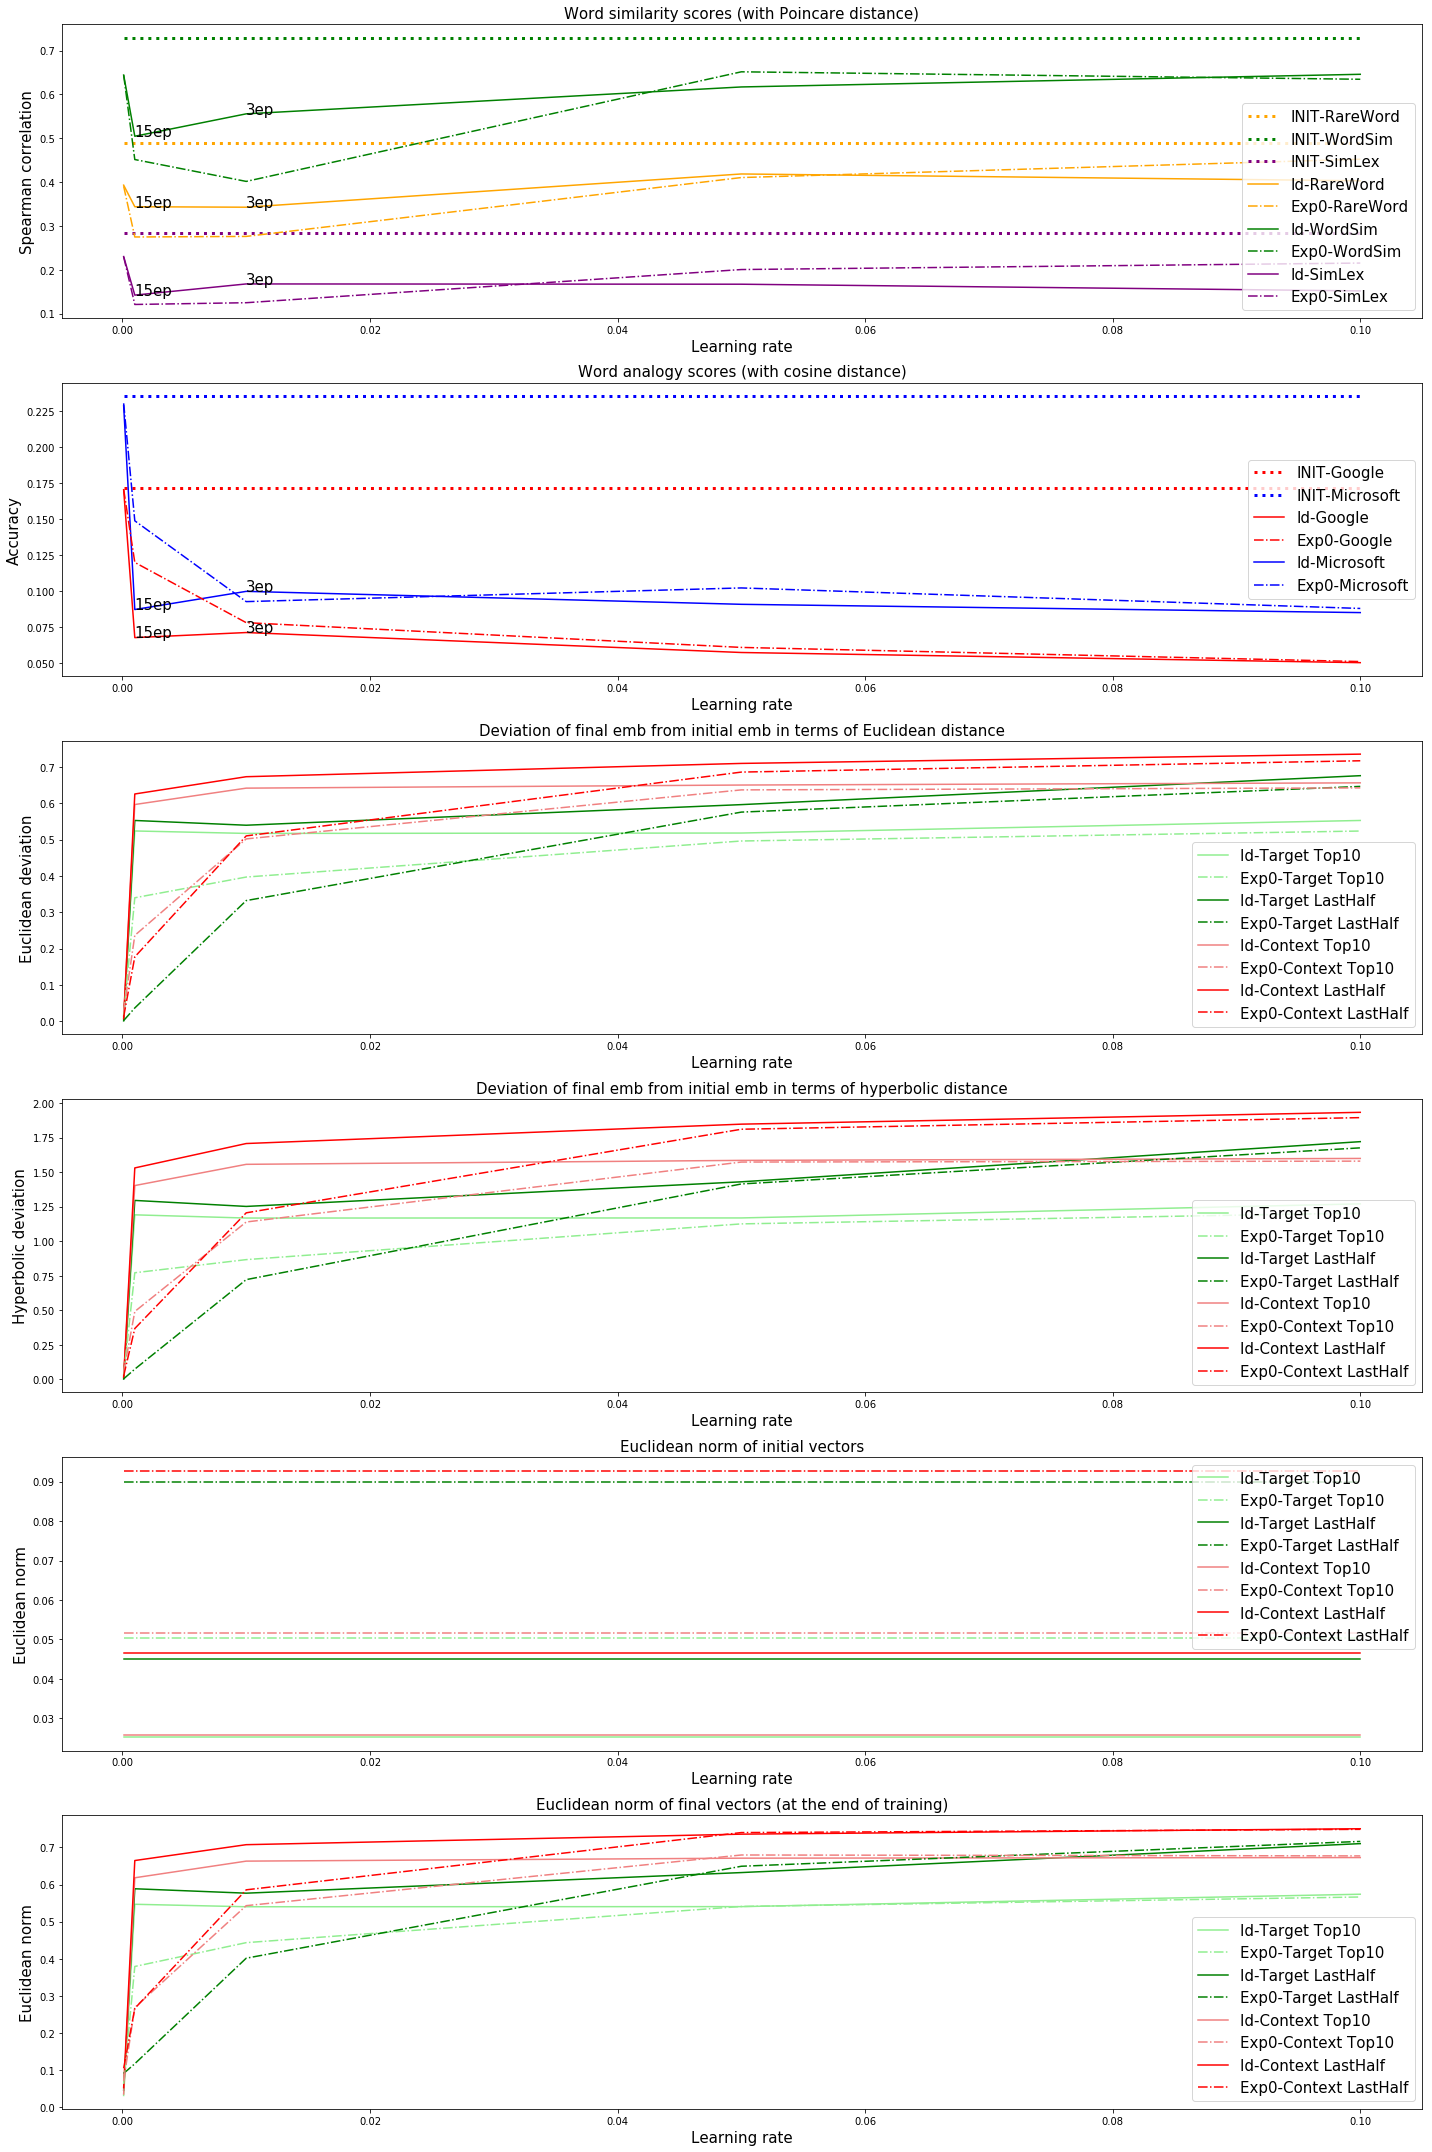

In [164]:
plot_and_process_experiment_list(lr_experiments, Quantities.LR)

## Vary scaling factor for a small lr (0.0001)

#### Remarks
- Word similarity doesn't change, regardless of the scaling factor or euclid2hyp transform. This means that the **relative distances** between points **are conserved** during the transformation. There is a slight decrease in the similarity score for large scaling factors (i.e. 0.9, 0.999), especially when using exp_0. The effect of exp_0 is even more striking on the analogy score, for large scaling factors.
<br>
- I checked, and for this experiment, where the learning rate was very small, **the scores** reported here, at the end of training, **are similar to what is obtained when evaluating the pretrained embeddings** after they are scaled and projected onto the Poincare ball. This is because the vectors don't deviate too much from their original position.
<br>

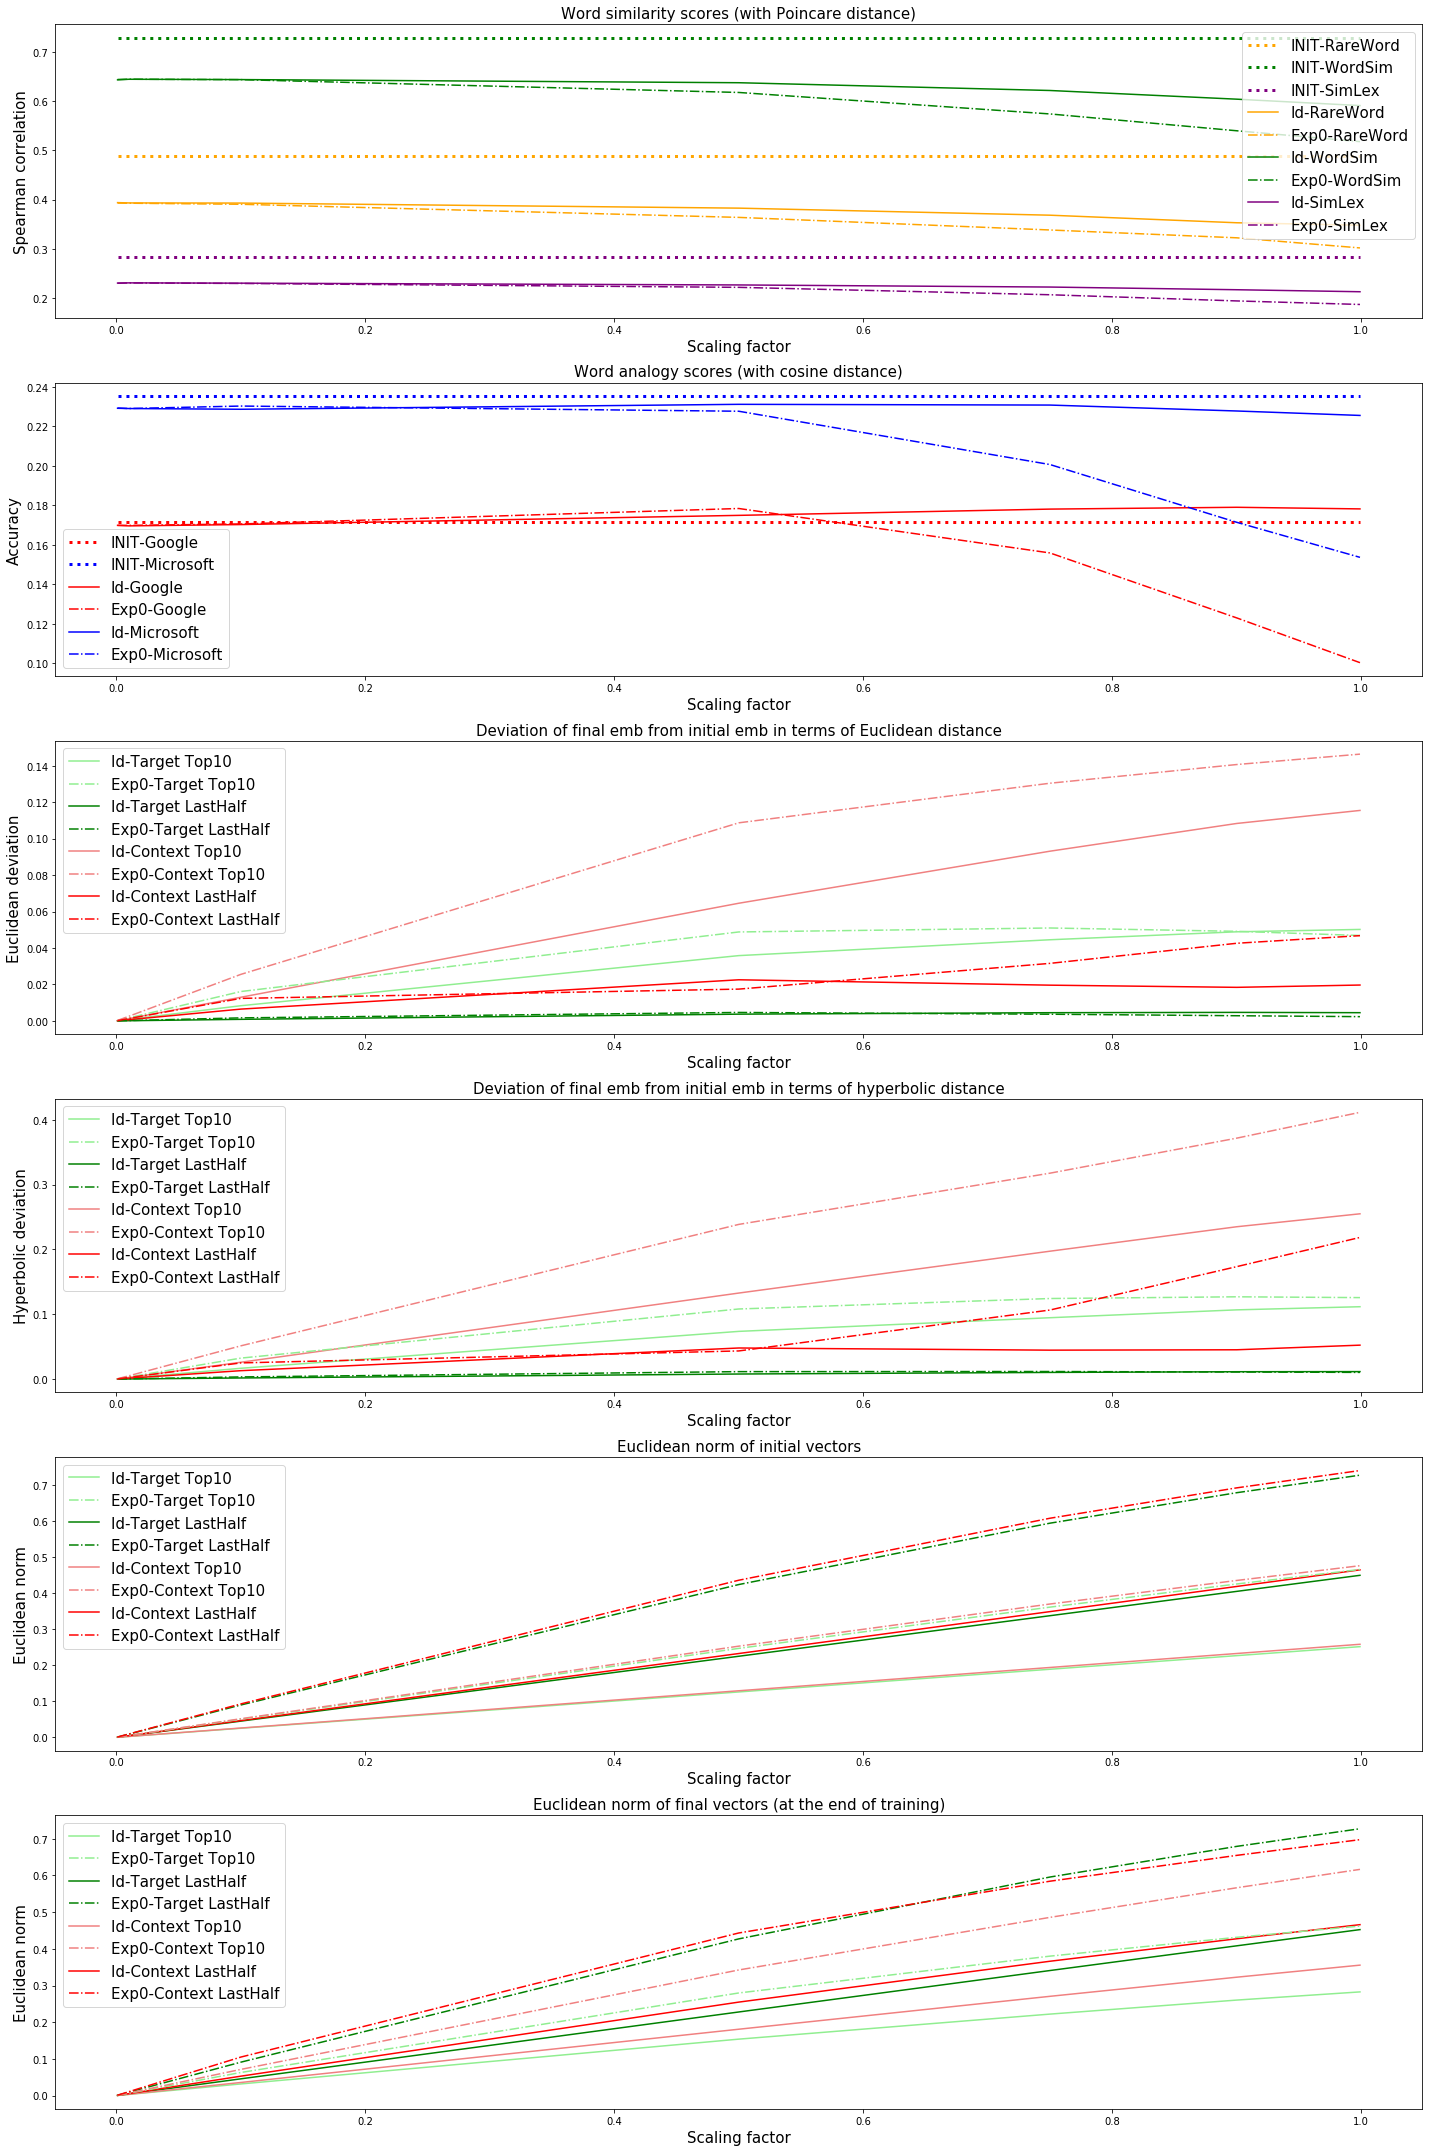

In [155]:
plot_and_process_experiment_list(scaling_experiments_small_lr, Quantities.SCALING_FACTOR)

## Vary scaling factor for a large lr (0.05->0.001)

#### Remarks
- Similarity scores seem to be the same as in the experiment with a small learning rate. This means that, even with a large learning rate, the model still preserves the relative distances between words, during training. Probably, the fact that I weighed the lr by a function of the frequency of each word helps in keeping all distances in sync, even if more frequent words are updated more frequently.
<br>
- Analogy is very bad, even compared to the experiment with a small learning rate. This means that **the large learning rate is hurting analogy accuracy**.
<br>
- I am scaling the points such that all of them are within the unit ball (including the outliers). This means that the vast majority of the points end up being concentrated somewhere around the middle of the ball or even closer to the origin (norms of ~0.4-0.6 for exp_0 or ~0.2-0.4 for id when scaling with 0.9, for instance). However, when using a large enough learning rate (e.g. like the one used for this experiment), the **embedding norms seem to always converge towards the region near 1/2 of the ball (~0.5-0.75)** (I took this data from my train_logs; it's not in the graphs).
<br>
- The observation above explains the behavior noticed in the Euclidean/hyperbolic deviation plots: the Euclidean deviation decreases with the scaling factor, because the larger the scaling factor, the more spread the points are i.e. norms are closer to 1/2. However, the hyperbolic distance stays pretty much the same, because at 1/2 from the origin, the Poincare distance between close points is already larger.

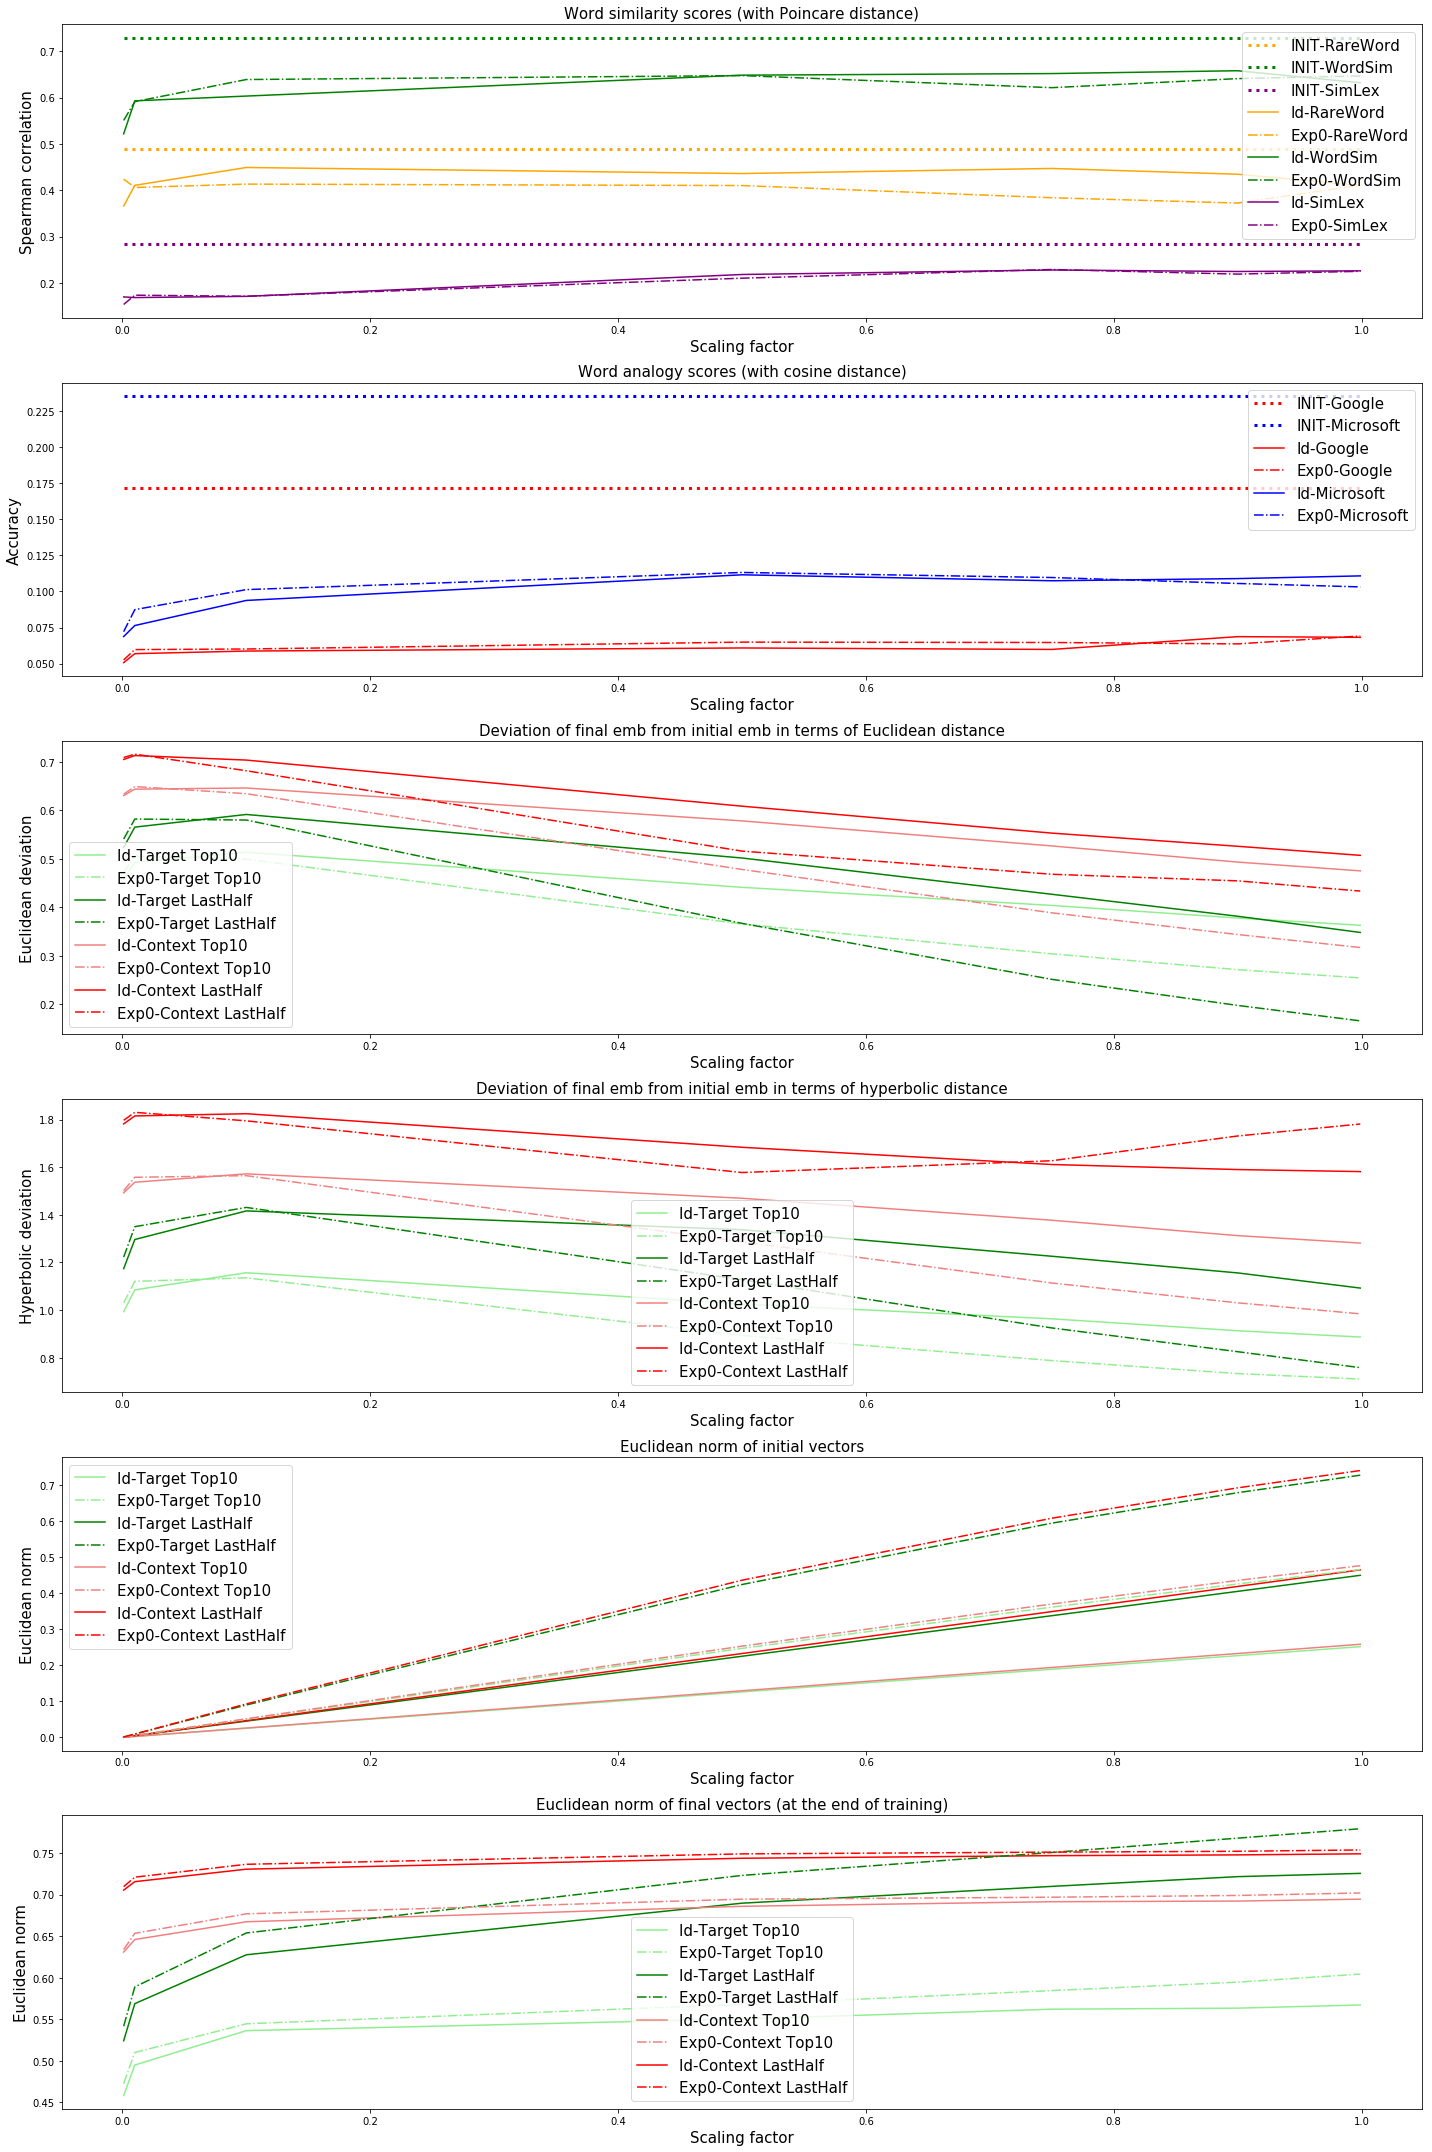

In [165]:
plot_and_process_experiment_list(scaling_experiments_large_lr, Quantities.SCALING_FACTOR)